# Explore Ki67 as proxy of aggressiveness

In [1]:
import os
import numpy as np
import anndata as ad
import pandas as pd
import scanpy as sc
from plotnine import *

In [2]:
adata = ad.read_h5ad('../../data/adata_consensus_cell_types.h5ad')

In [3]:
clini = pd.read_csv("../../data/summary_clinical_data_modified.csv", index_col=2)
adata.obs = adata.obs.merge(clini, left_on="fov", right_index=True, how="left")
adata.obs["Stage"] = adata.obs["pT group"]
# # E1 and E2 samples are annotated 'SCT' while E3 and E4 are 'Colon-no.'
adata.obs.loc[adata.obs.fov.str.contains("E4"), "Stage"] = "Colon-no."
adata.obs.loc[adata.obs.fov.str.contains("E3"), "Stage"] = "Colon-no."
adata.obs.loc[adata.obs.fov.str.contains("E2"), "Stage"] = "SCT"
adata.obs.loc[adata.obs.fov.str.contains("E1"), "Stage"] = "SCT"

We want a DataFrame with, for each cancer cell, the corresponding FOV, pT stage, Ki67 level.

In [4]:
df = adata[adata.obs["annotation_consensus"] == "Cancer_cell"].obs.loc[:,["fov", "Ki67", 'Stage']]
# Drop rows with missing Stage values
df = df.loc[~df.Stage.isna(), :]

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 20519 rows containing non-finite values.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 20519 rows containing non-finite values.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


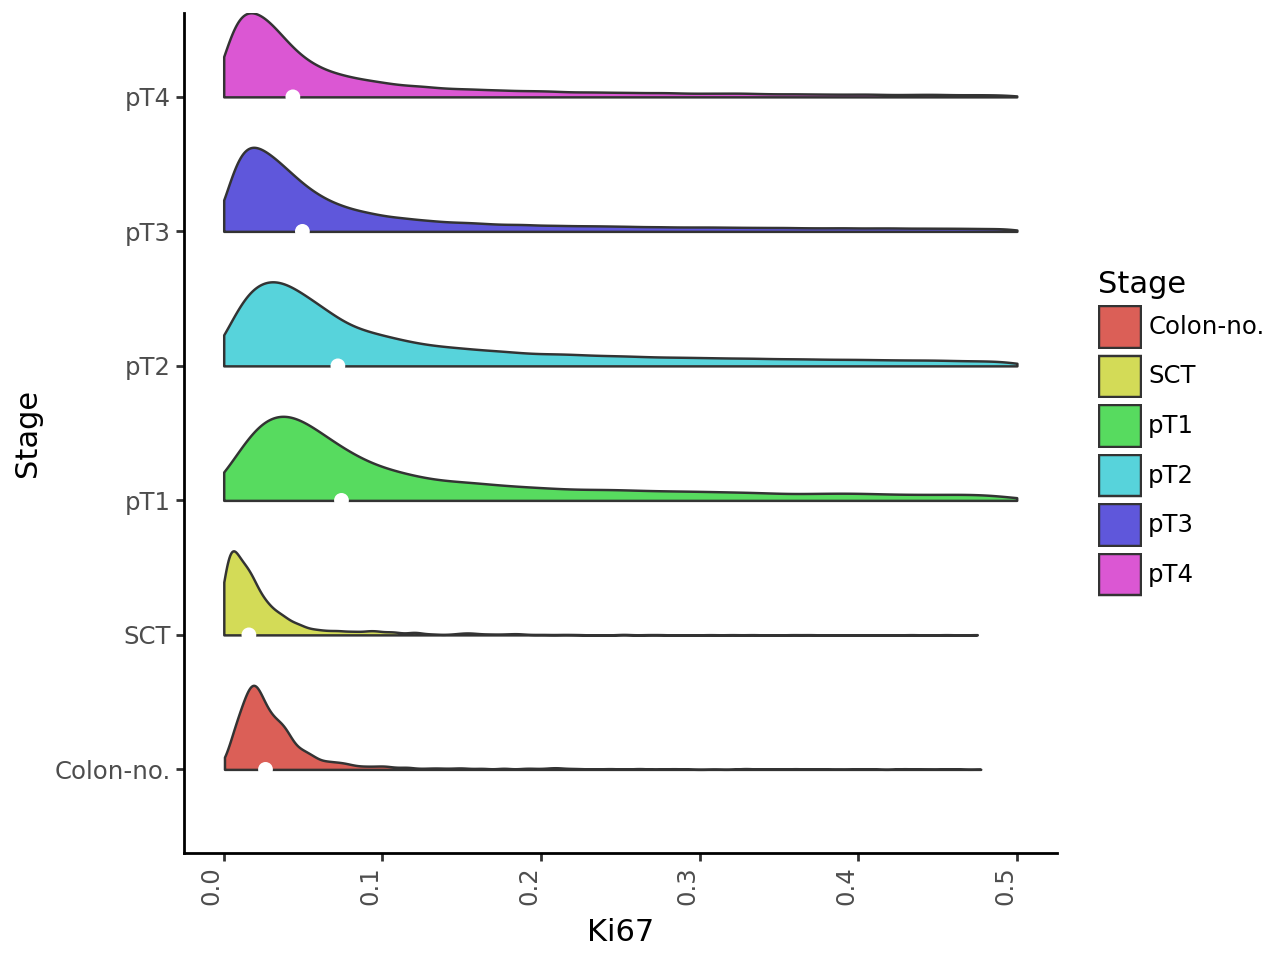

In [5]:
ggplot(df, aes(x="Stage", y="Ki67")) +\
    geom_violin(aes(fill = "Stage"), style="right", scale="width", width = 1.25) +\
    stat_summary(fun_y=np.median, geom='point', color='white', size=2) +\
    theme_classic() +\
    theme(axis_text_x=element_text(rotation=90, hjust=1)) +\
    coord_flip() +\
    ylim(0,0.5)

## Compare metabolism of Ki67hi and Ki67lo cancer cells

In [6]:
df = pd.DataFrame(adata[(adata.obs["annotation_consensus"] == "Cancer_cell") &
           (adata.obs["Stage"] != "SCT") &
           (adata.obs["Stage"] != "Colon-no.")].obs)

In [7]:
agg_low = np.percentile(df["Ki67"], 20)
agg_hi = np.percentile(df["Ki67"], 80)

df["Aggressiveness"] = ["High" if x > agg_hi else "Low" if x < agg_low else "Intermediate" for x in df["Ki67"]]

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.25 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/ki67_histogram.pdf


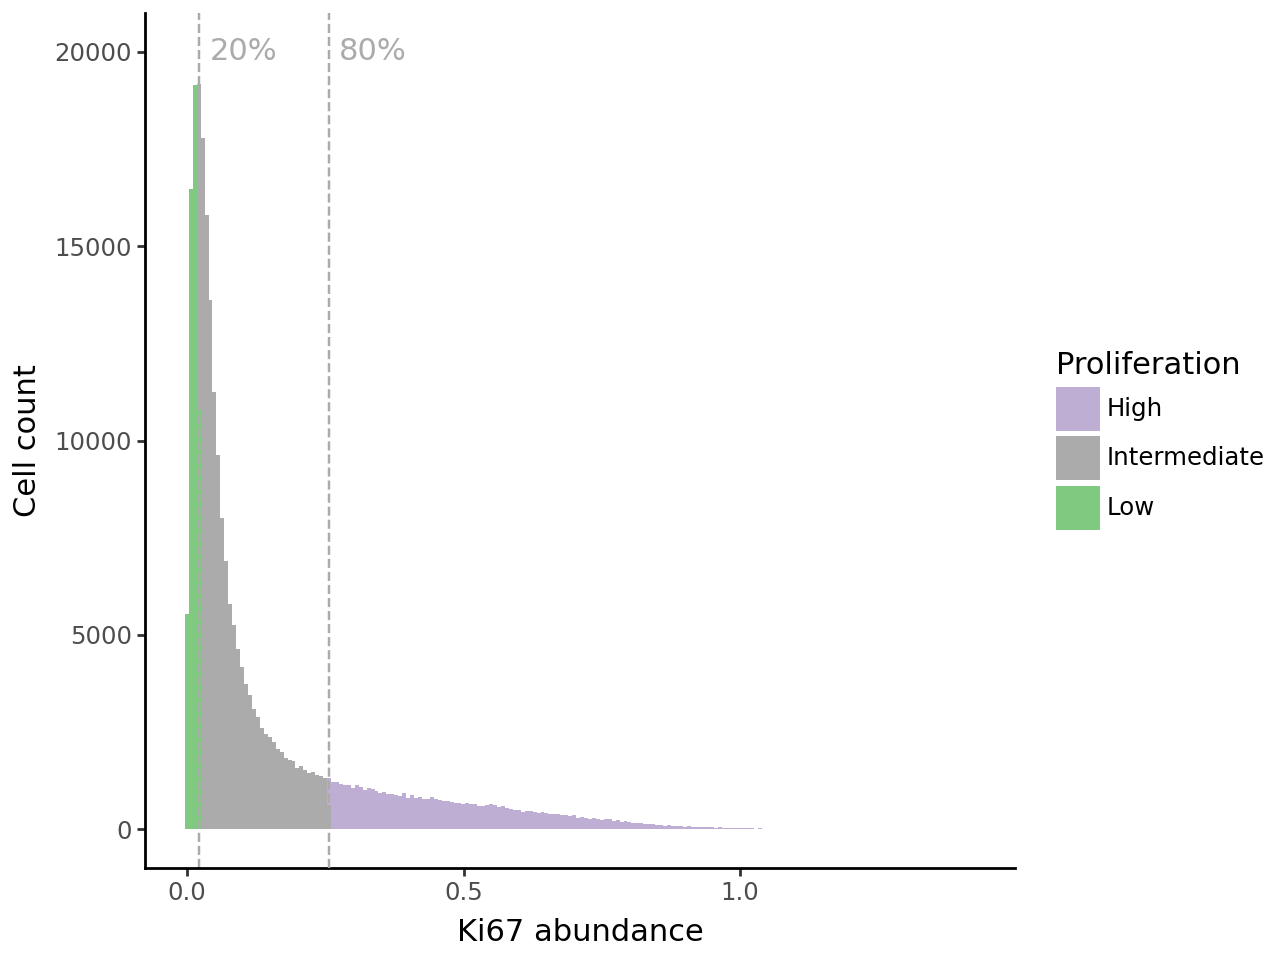

In [8]:
gp = (
    ggplot(df, aes(x="Ki67")) +
    geom_histogram(aes(fill="Aggressiveness"), bins=200) +
    scale_fill_manual(values=["#beaed4", "#acabab", "#7fc980"]) +
    theme_classic() +
    xlab("Ki67 abundance") +
    ylab("Cell count") +
    geom_vline(xintercept=agg_low, linetype="dashed", color="#acabab") +
    geom_vline(xintercept=agg_hi, linetype="dashed", color="#acabab") +
    annotate(geom="text", x=[0.08 + agg_low, 0.08 + agg_hi], y=20000, label=["20%", "80%"], color="#acabab") +
    guides(fill=guide_legend(title="Proliferation"))
)
gp.save("../../figures/fig3/ki67_histogram.pdf", width=6, height=2.25)
gp

In [9]:
df["PanCK"] = adata[(adata.obs["annotation_consensus"] == "Cancer_cell") &
    (adata.obs["Stage"] != "SCT") &
    (adata.obs["Stage"] != "Colon-no.")].X[:,adata.var_names == "PanCK"].flatten().tolist()

In [10]:
all_metab_col = ['CA9', 'CD98', 'CytC', 'MSH2', 'MCT1', 'ASCT2',
       'LDH', 'GS', 'GLS', 'ATP5A', 'CS', 'PKM2', 'GLUT1', 'MSH6', 'ARG1', 'CPT1A']
meta_col = ["Aggressiveness", "Stage", "fov"]

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/intensity_ki67_cancer.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 586 rows containing non-finite values.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 897 rows containing non-finite values.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_summary : Removed 1483 rows containing non-finite values.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/layer.py:284: PlotnineWarning: stat_ydensity : Removed 586 rows containing non-finite values.
/home/loan/miniforge3/en

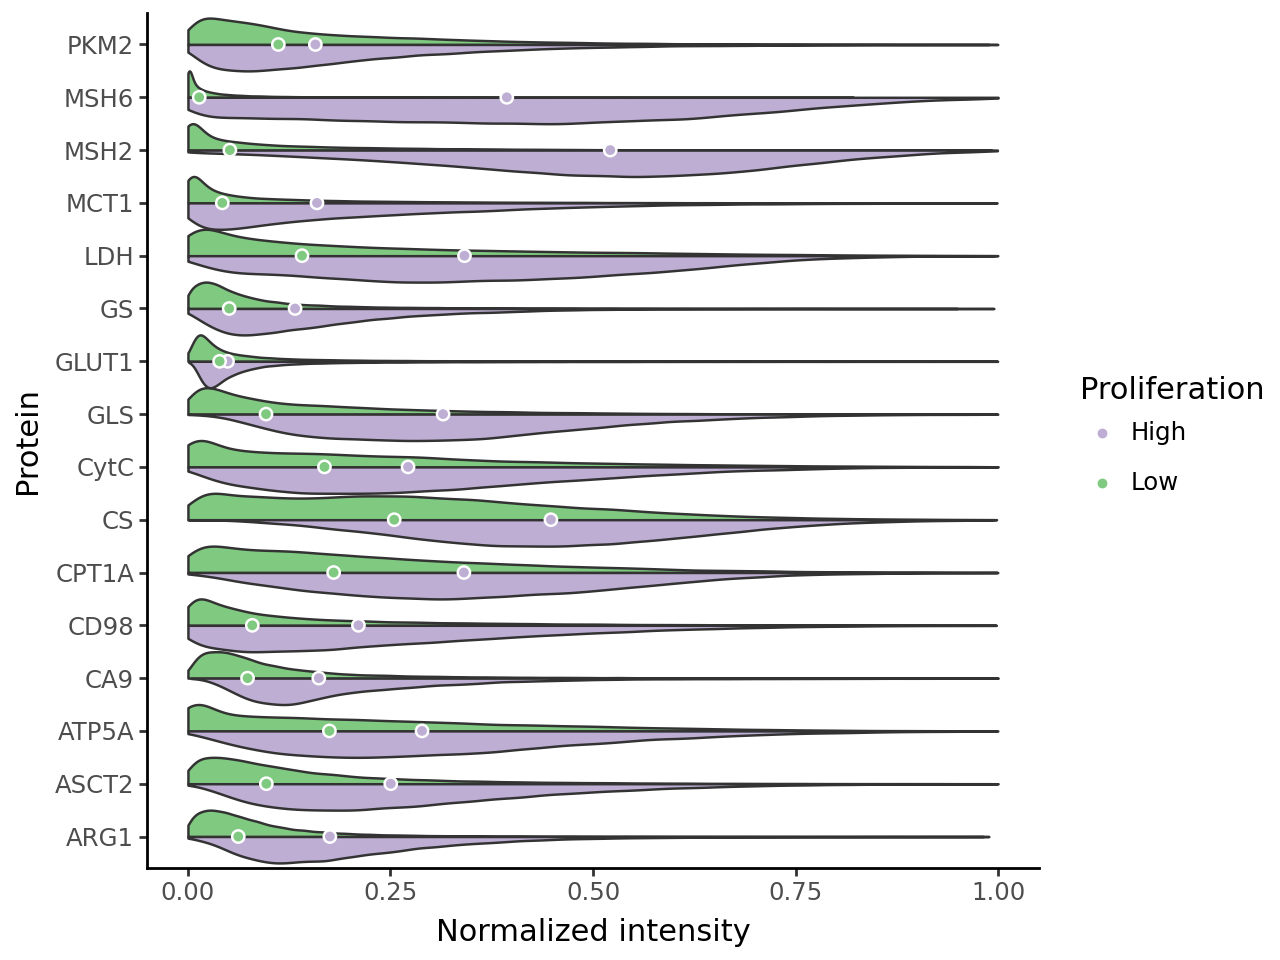

In [11]:
# Display violin plots of metabolic marker intensity per cell
# Split by aggressiveness (low = right violin, high = left violin)

# Convert to long format
df_long = pd.melt(df.loc[:,all_metab_col+meta_col], id_vars=meta_col, value_vars=all_metab_col)

gp = ggplot(df_long, aes(x="variable", y="value")) +\
    geom_violin(data = df_long.loc[df_long.Aggressiveness == "Low",:], 
                fill = "#7fc980", 
                style="right", 
                scale="width", 
                width = 1) +\
    geom_violin(data = df_long.loc[df_long.Aggressiveness == "High",:], 
                fill = "#beaed4", 
                style="left", 
                scale="width", 
                width = 1) +\
    stat_summary(data = df_long.loc[df_long.Aggressiveness != "Intermediate",:], 
                 mapping = aes(fill = "Aggressiveness"),
                 fun_y=np.median, geom='point', color='white', 
                 size=2) +\
    scale_fill_manual(values = ["#beaed4", "#7fc980"]) +\
    theme_classic() +\
    coord_flip() +\
    ylab("Normalized intensity") +\
    xlab("Protein") +\
    ylim(0,1) +\
    guides(fill=guide_legend(title="Proliferation"))

ggsave(gp, "../../figures/fig3/intensity_ki67_cancer.pdf", width = 6, height = 4.5)
gp

In [12]:
df.Aggressiveness.value_counts()

Aggressiveness
Intermediate    155816
Low              51939
High             51939
Name: count, dtype: int64

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 4.5 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/intensity_ki67_healthy.pdf


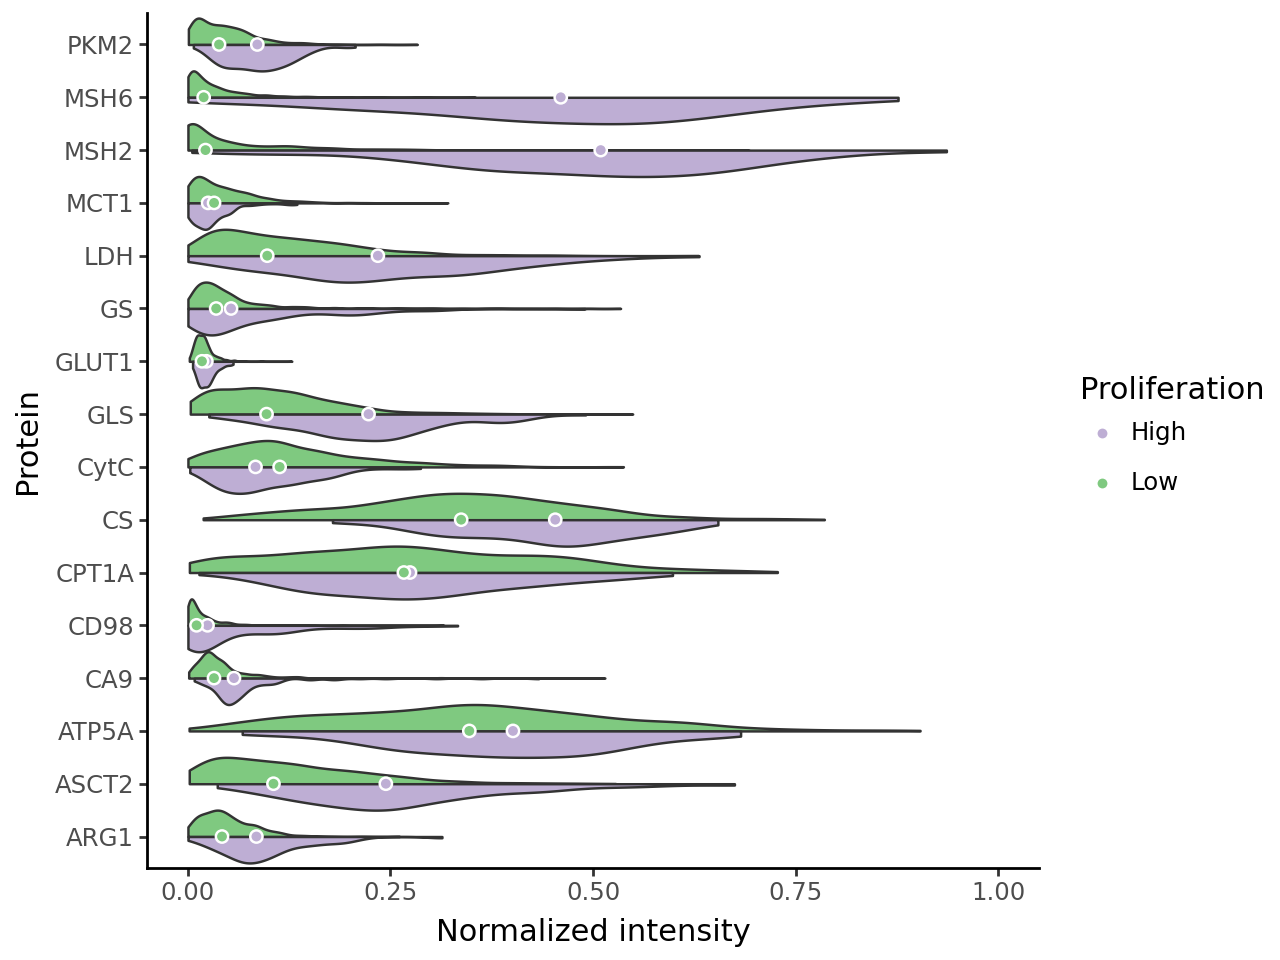

In [13]:
# Repeat for healthy stage
df = pd.DataFrame(adata[(adata.obs["annotation_consensus"] == "Cancer_cell") &
           (adata.obs["Stage"] == "Colon-no.")].obs)

# Thresholds are kept identical
df["Aggressiveness"] = ["High" if x > agg_hi else "Low" if x < agg_low else "Intermediate" for x in df["Ki67"]]

df["PanCK"] = adata[(adata.obs["annotation_consensus"] == "Cancer_cell") &
    (adata.obs["Stage"] == "Colon-no.")].X[:,adata.var_names == "PanCK"].flatten().tolist()

# Convert to long format
df_long = pd.melt(df.loc[:,all_metab_col+meta_col], id_vars=meta_col, value_vars=all_metab_col)

gp = ggplot(df_long, aes(x="variable", y="value")) +\
    geom_violin(data = df_long.loc[df_long.Aggressiveness == "Low",:], 
                fill = "#7fc980", 
                style="right", 
                scale="width", 
                width = 1) +\
    geom_violin(data = df_long.loc[df_long.Aggressiveness == "High",:], 
                fill = "#beaed4", 
                style="left", 
                scale="width", 
                width = 1) +\
    stat_summary(data = df_long.loc[df_long.Aggressiveness != "Intermediate",:], 
                 mapping = aes(fill = "Aggressiveness"),
                 fun_y=np.median, geom='point', color='white', 
                 size=2) +\
    scale_fill_manual(values = ["#beaed4", "#7fc980"]) +\
    theme_classic() +\
    coord_flip() +\
    ylab("Normalized intensity") +\
    xlab("Protein") +\
    ylim(0,1) +\
    guides(fill=guide_legend(title="Proliferation"))

ggsave(gp, "../../figures/fig3/intensity_ki67_healthy.pdf", width = 6, height = 4.5)
gp

More changes in CPT1A, CytC and MCT1 in malignant cells than healthy?  
Double check that the Ki67+ cells in healthy samples are truly healthy.

In [14]:
df.Aggressiveness.value_counts()

Aggressiveness
Intermediate    916
Low             642
High            118
Name: count, dtype: int64

## Proportion of Ki67+ per sample

/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:606: PlotnineWarning: Saving 6 x 2.25 in image.
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/ggplot.py:607: PlotnineWarning: Filename: ../../figures/fig3/ki67_fraction_per_stage.pdf
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals
/home/loan/miniforge3/envs/pam-keras3/lib/python3.11/site-packages/plotnine/positions/position.py:232: PlotnineWarning: position_dodge requires non-overlapping x intervals


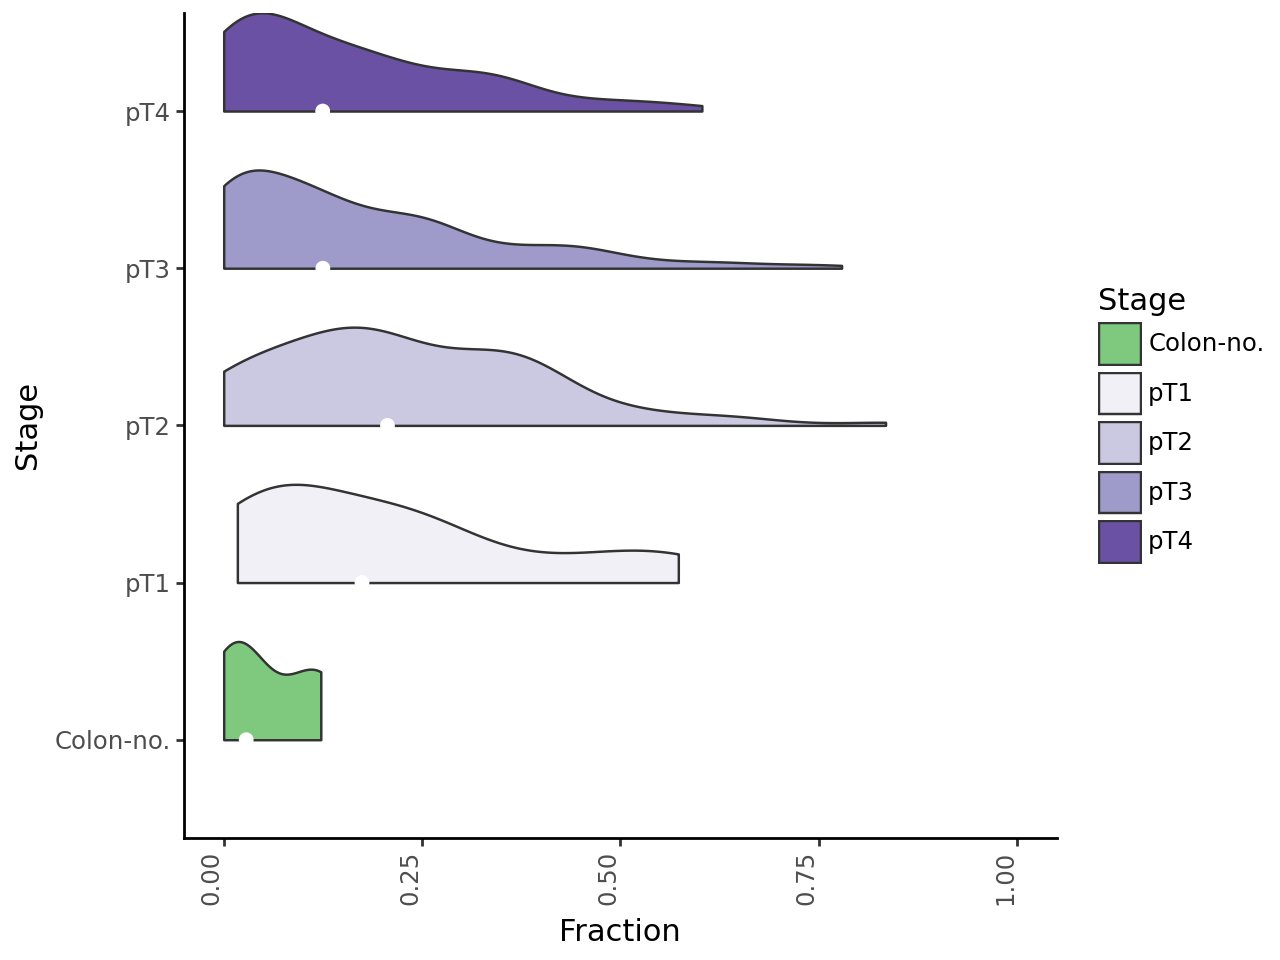

In [15]:
# Purples + Green for healthy
pal_stages = [(127,201,127), (242,240,247), (203,201,226), (158,154,201), (106,81,163)]
# Convert to hex
pal_stages = ['#%02x%02x%02x' % (r, g, b) for r, g, b in pal_stages]

df = pd.DataFrame(adata[(adata.obs["annotation_consensus"] == "Cancer_cell")].obs)

# Check if Ki67 is higher than agg_hi
df['high_Ki67'] = df['Ki67'] > agg_hi

# Group by the fov column and compute the fraction of rows with high Ki67
df_frac = pd.DataFrame({"Fraction": df.groupby('fov')['high_Ki67'].mean(),
                       "Stage": df.groupby('fov')['Stage'].first()})

gp = ggplot(df_frac[df_frac.Stage.isin(["Colon-no.", "pT1", "pT2", "pT3", "pT4"])], aes(x="Stage", y="Fraction")) +\
    geom_violin(aes(fill = "Stage"), style="right", scale="width", width = 1.25) +\
    stat_summary(fun_y=np.median, geom='point', color='white', size=2) +\
    theme_classic() +\
    scale_fill_manual(values=pal_stages) +\
    theme(axis_text_x=element_text(rotation=90, hjust=1)) +\
    coord_flip() +\
    ylim(0,1)

ggsave(gp, "../../figures/fig3/ki67_fraction_per_stage.pdf", width = 6, height = 2.25)
gp